In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [44]:
# Function to Remove Commas and Convert to Floats
def remove_commas(value):
    if isinstance(value, str):
        if ',' in value:
            return float(value.replace(',', ''))

# Read the data from the Central Energy Plant and clean up the data
plant_data = pd.read_csv('Plant Steam Data.csv', nrows=9000)
plant_data.columns = ['date', 'time', 'pressure', 'steam flow', 'air temp', 'facility pressure']
steam_usage = pd.read_csv('Steam Usage Year.csv')
steam_usage = steam_usage.drop(columns=['Unnamed: 2', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19'])
steam_usage = steam_usage.rename(columns={'Unnamed: 0': 'Building', 'Unnamed: 1': 'MeterNo'})
steam_usage = steam_usage.drop([0]).reset_index(drop=True)
data_months = ['Sep-24', 'Aug-24', 'Jul-24', 'Jun-24', 'May-24', 'Apr-24', 'Mar-24', 'Feb-24', 'Jan-24', 'Dec-23', 'Nov-23', 'Oct-23']
for month in data_months:
    data = steam_usage[month]
    for i in range(len(data)):
        data[i] = round(float(data[i]), 2)


In [45]:
# Show the first few rows of the plant data, steam flow is in lb/hr
plant_data.head()

,date,time,pressure,steam flow,air temp,facility pressure
0,10/16/2024,7:00:00 AM,88.45,23397.28,52.46,69.75
1,10/16/2024,6:00:00 AM,90.40,18584.67,53.20,72.36
2,10/16/2024,5:00:00 AM,90.74,17030.57,54.41,72.54
3,10/16/2024,4:00:00 AM,90.78,15487.72,55.27,72.61
4,10/16/2024,3:00:00 AM,90.79,15050.83,56.00,72.90


In [46]:
# Show the first few rows of the steam usage data, usage data is in lbs/month
steam_usage.head()

,Building,MeterNo,Sep-24,Aug-24,Jul-24,Jun-24,May-24,Apr-24,Mar-24,Feb-24,Jan-24,Dec-23,Nov-23,Oct-23
0,Spectrum,7001,188349.63,175837.97,188216.35,201819.24,254298.24,420523.39,501457.67,670398.4,270591.72,262836.49,374283.56,336207.13
1,HPER,7002,496121.82,428632.85,301262.95,376176.62,551236.28,1241250.35,1754496.48,2184241.26,2533989.86,2360073.89,1954505.15,1633268.0
2,Family Life,7003,0.0,0.0,0.0,0.0,107670.0,196210.0,265330.0,254850.0,343760.0,323570.0,301520.0,194380.0
3,Maeser,7004,245638.0,217663.0,206800.0,222726.0,291209.0,381654.0,550546.0,623689.0,777253.0,730016.0,556323.0,361156.0
4,TSC,7006,198658.72,162076.85,187992.48,246323.48,407983.68,544894.87,673223.07,852632.56,938545.79,873548.39,605475.78,327486.9


In [47]:
# Grab the time data for the most recent full day
start_index = 8
end_index = start_index + 24
times = plant_data['time'][start_index:end_index].values
hour_values = []
for time in times:
    number, period = time.split(' ')
    hour, minute, second = number.split(':')
    if period == 'PM':
        if hour != '12':
            hour = int(hour) + 12
    else:
        if hour == '12':
            hour = 0
    hour_values.append(int(hour))

# Grab the steam flow data for the most recent full day
steam_flows = plant_data['steam flow'][start_index:end_index].values
m_dot_steam = []
for i in range(len(steam_flows)):
    m_dot_steam.append(round(float(steam_flows[i]) / 1000, 3))

# Grab the outside air temperature data for the most recent full day
air_temps = plant_data['air temp'][start_index:end_index].values
t_air = []
for i in range(len(air_temps)):
    t_air.append(float(air_temps[i]))

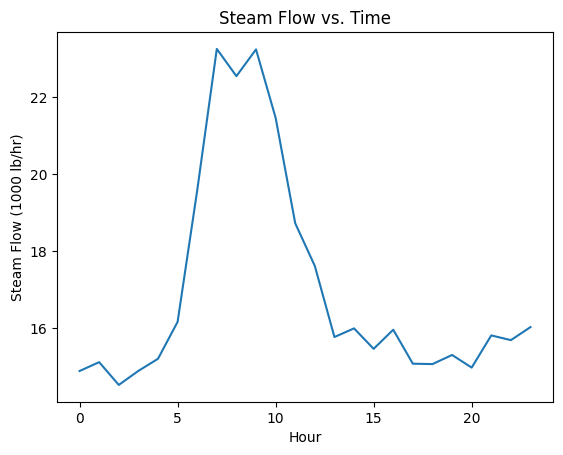

In [48]:
plt.plot(hour_values, m_dot_steam)
plt.xlabel('Hour')
plt.ylabel('Steam Flow (1000 lb/hr)')
plt.title('Steam Flow vs. Time')
plt.show()

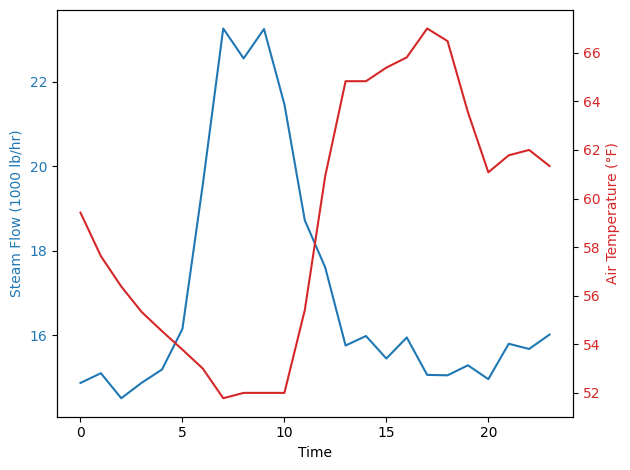

In [49]:
fig, ax1 = plt.subplots()

# Plot steam flow data
ax1.set_xlabel('Time')
ax1.set_ylabel('Steam Flow (1000 lb/hr)', color='tab:blue')
ax1.plot(hour_values, m_dot_steam, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to plot air temperature data
ax2 = ax1.twinx()
ax2.set_ylabel('Air Temperature (°F)', color='tab:red')
ax2.plot(hour_values, t_air, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()

In [50]:
# Sum all values in the 'Mar-24' column
total_mar_24 = round(steam_usage['Mar-24'].sum(), 2)
print(total_mar_24)

23527183.77


In [ ]:
def fix_na(col):
    prev_is_na = False
    before = 0.0
    na_idxs = []
    for i in range(len(col)):
        if not prev_is_na and col[i] == 'n/a':
            prev_is_na = True
            before = col[i - 1]
            na_idxs.append(i)
        elif prev_is_na and col[i] == 'n/a':
            na_idxs.append(i)
        elif prev_is_na and col[i] != 'n/a':
            col[i] = float(col[i])
            prev_is_na = False
            ave = (before + col[i]) / 2
            for j in na_idxs:
                col[j] = ave
            na_idxs = []
            before = 0.0
        else:
            col[i] = float(col[i])

In [51]:
# Grab and clean all data from the plant data
all_dates = plant_data['date'].values
all_times = plant_data['time'].values
all_pressures = plant_data['pressure'].values
all_steam_flows = plant_data['steam flow'].values
all_air_temps = plant_data['air temp'].values
all_facility_pressures = plant_data['facility pressure'].values
months, days, years = [], [], []
for date in all_dates:
    #print(str(date))
    month, day, year = date.split('/')
    months.append(int(month))
    days.append(int(day))
    years.append(int(year))

hours = []
for time in all_times:
    number, period = time.split(' ')
    hour, minute, second = number.split(':')
    if period == 'PM':
        if hour != '12':
            hour = int(hour) + 12
    else:
        if hour == '12':
            hour = 0
    hours.append(int(hour))

# Create a new DataFrame with the cleaned up data
cleaned_plant_data = pd.DataFrame({
    'Month': months,
    'Day': days,
    'Year': years,
    'Hour': hours,
    'Pressure': all_pressures,
    'Steam Flow': all_steam_flows,
    'Air Temp': all_air_temps,
    'Facility Pressure': all_facility_pressures
})

cleaned_plant_data.head()

           date         time  pressure steam flow air temp facility pressure
8995  10/7/2023  12:00:00 PM     88.33   21449.28    59.27             70.12
8996  10/7/2023  11:00:00 AM     90.18   21140.97    55.26             72.30
8997  10/7/2023  10:00:00 AM     88.95   24528.35    49.48             70.87
8998  10/7/2023   9:00:00 AM     88.64   25987.34    47.02             70.15
8999  10/7/2023   8:00:00 AM     88.77   24841.15    47.11             70.29


,Month,Day,Year,Hour,Pressure,Steam Flow,Air Temp,Facility Pressure
0,10,16,2024,7,88.45,23397.28,52.46,69.75
1,10,16,2024,6,90.40,18584.67,53.20,72.36
2,10,16,2024,5,90.74,17030.57,54.41,72.54
3,10,16,2024,4,90.78,15487.72,55.27,72.61
4,10,16,2024,3,90.79,15050.83,56.00,72.90


In [55]:
enthalpy_ss_90 = 2764.04
enthalpy_sw_atm = 418.99

def heat_transferred(m_dot, h1, h2):
    return round(m_dot * (h2 - h1), 2)

Total Energy Transferred in September
Spectrum: 441689.3 MJ
HPER: 1163430.47 MJ
Family Life: 0.0 MJ
Maeser: 576033.39 MJ
TSC: 465864.63 MJ
TSC: 1327636.03 MJ
FeildHouse: 375153.9 MJ
Ind Science: 184606.67 MJ
ECC: 122523.96 MJ
INN: 412712.29 MJ
Facilities: 87154.21 MJ
NFS: 464474.67 MJ
Business: 715606.08 MJ
BNR: 1193367.76 MJ
NR: 83070.07 MJ
HSRC: 104116.05 MJ
Eng New: 292904.58 MJ
Eng lab: 906911.81 MJ
Merrill: 137922.5 MJ
FA Center: 382931.35 MJ
FA Museum: 398264.53 MJ
LLC: 740498.08 MJ
FA Visual: 455546.83 MJ
Richards: 194650.9 MJ
SER: 453182.32 MJ
Junction: 486117.14 MJ
Bullen: 137824.8 MJ
Old Main: 422287.53 MJ
Forage Range: 622546.78 MJ
Geology: 406263.66 MJ
Ray B West: 166237.85 MJ
Biotech: 519056.06 MJ
Education: 209345.97 MJ
Sci Tech Lib: 253841.51 MJ
Widtsoe: 699160.24 MJ
Edith Bowen: 265682.44 MJ
Forestry Science: 73494.83 MJ
Uni Reserve: 69500.25 MJ
Alumni: 25306.0 MJ
Quinney Lawson: 106578.25 MJ
Perf Hall: 93446.51 MJ
MC Lib: 453162.79 MJ
Eng Sant: 186424.02 MJ
Vet Science

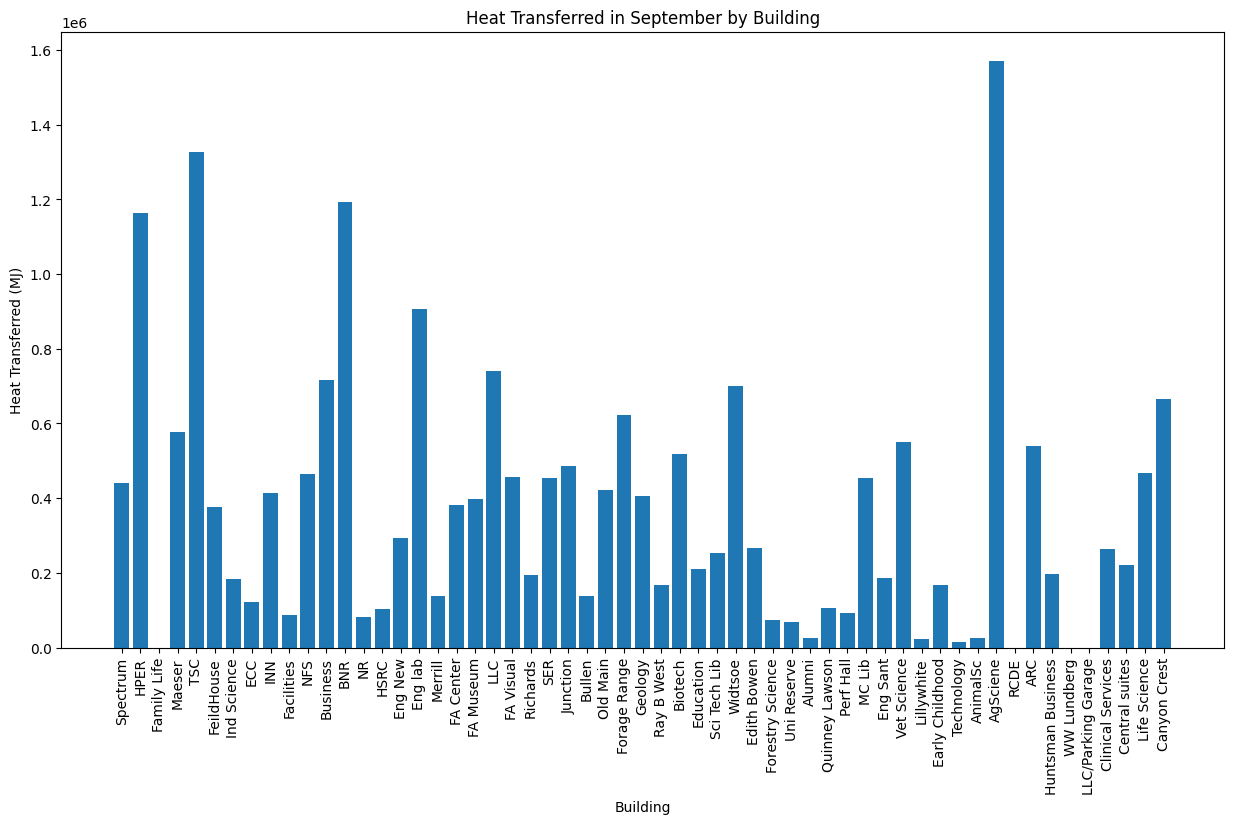

In [61]:
september_steam = steam_usage['Sep-24'].values
buildings = steam_usage['Building'].values
september_steam = [round(float(value), 2) for value in september_steam]
september_heat = []
for i in range(len(september_steam)):
    september_heat.append(heat_transferred(september_steam[i], enthalpy_sw_atm, enthalpy_ss_90))

print("Total Energy Transferred in September")
for i in range(len(buildings)):
    print(buildings[i] + ': ' + str(round(september_heat[i]/1000, 2)) + ' MJ')

plt.figure(figsize=(15, 8))
plt.bar(buildings, [heat / 1000 for heat in september_heat])
plt.xlabel('Building')
plt.ylabel('Heat Transferred (MJ)')
plt.title('Heat Transferred in September by Building')
plt.xticks(rotation=90)
plt.show()
